In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [43]:
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress')
from ADlasso2 import AD2_w_utils_lossdiff as ad

In [3]:
import scanpy as sc
# import scvelo as scv

# read the full GSE dataset
data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
data.shape

(161764, 33538)

In [4]:
### Raw counts were not normalizaed
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

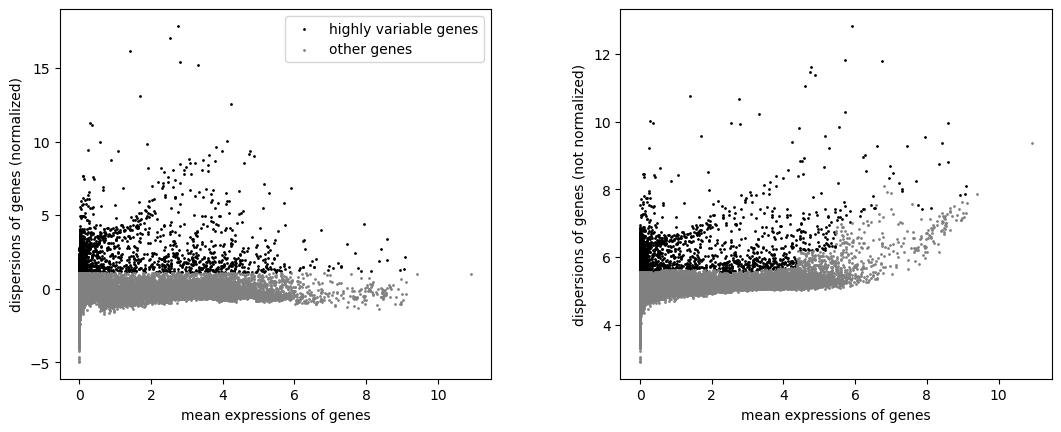

In [5]:
# Select HVG2000
sc.pp.highly_variable_genes(data, n_top_genes=2000)
sc.pl.highly_variable_genes(data)

In [10]:
data.obs['celltype.l1'] = data.obs['celltype.l1'].str.replace(' ', '_')

label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print(types)

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


In [11]:
data_hvg = data[:, data.var.highly_variable]
data_hvg.shape

(161764, 2000)

## Train one-vs-rest LR classifier on HVG2000

In [21]:
def LR_classifier(data, celltype):
    X = data.X
    # binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Predict the test set results
    y_pred = clf.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'average_precision': average_precision,
        'mcc': mcc
    }

    return clf, y_pred, metrics

In [71]:
def plot_HVG_profile(data_hvg, celltype, save_path=None):
    clf, yp, met = LR_classifier(data_hvg, celltype)

    y = np.array([1 if i==celltype else 0 for i in data_hvg.obs['celltype.l1'].tolist()])
    celltype_indices = [idx for idx, label in enumerate(y) if label == 1] 
    others_indices = [idx for idx, label in enumerate(y) if label == 0]
    others_prevalence = ad.get_prevalence(data_hvg.X, others_indices)
    celltype_prevalence = ad.get_prevalence(data_hvg.X, celltype_indices)

    # list to store if the HVG is a positive or negative feature
    hvg_type = []
    for coef in clf.coef_[0]:
        if coef > 0:
            hvg_type.append('HVG_Positive')
        else:
            hvg_type.append('HVG_Negative')

    prop = pd.DataFrame({'hvg_type': hvg_type, 'prevalence_0': others_prevalence, 'prevalence_1': celltype_prevalence})

    sns.scatterplot(x="prevalence_1", y="prevalence_0", palette=['#BCBCBC', 'r'], hue='hvg_type', alpha=0.5, data=prop)

    plt.xlabel('Target prevalence')
    plt.ylabel('Other prevalence')
    plt.title(f'{celltype}: selection profile')
    plt.legend(fontsize='small')
    if save_path:
        plt.savefig(save_path + f'/{celltype}_HVG_profile.png', dpi=300)
    plt.show()
    plt.close('all')

B


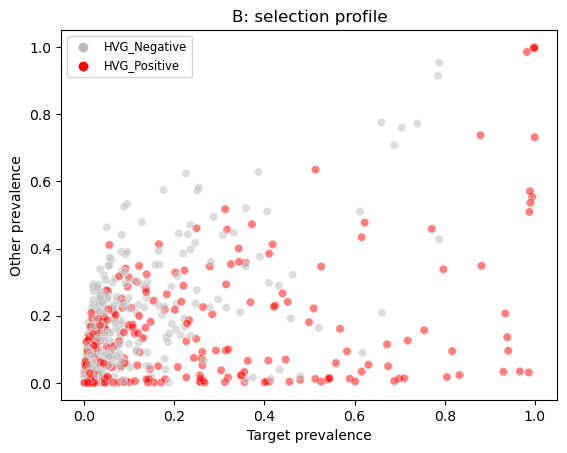

CD4_T


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


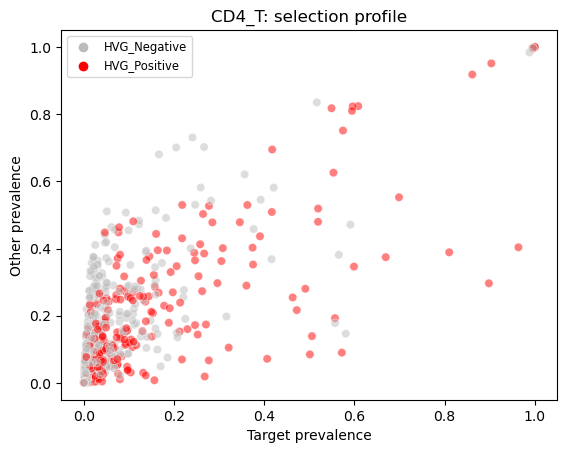

CD8_T


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


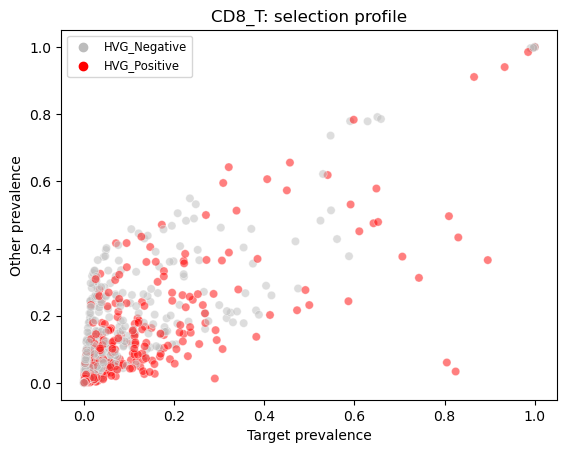

DC


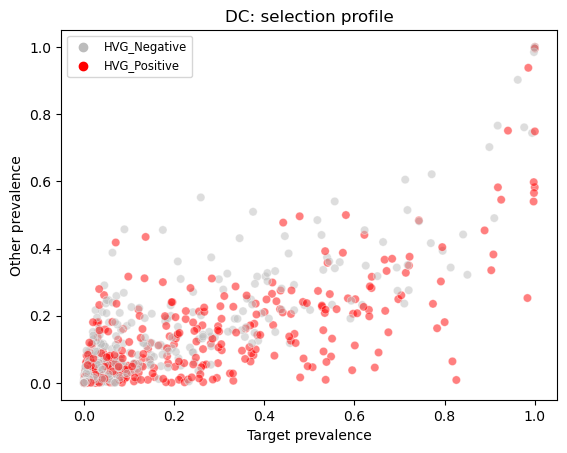

Mono


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


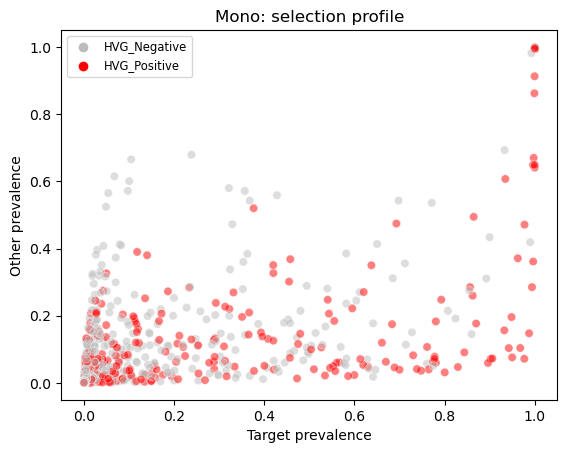

NK


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


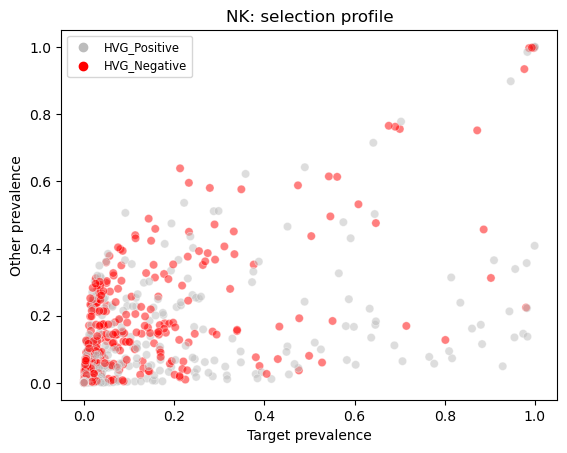

other


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


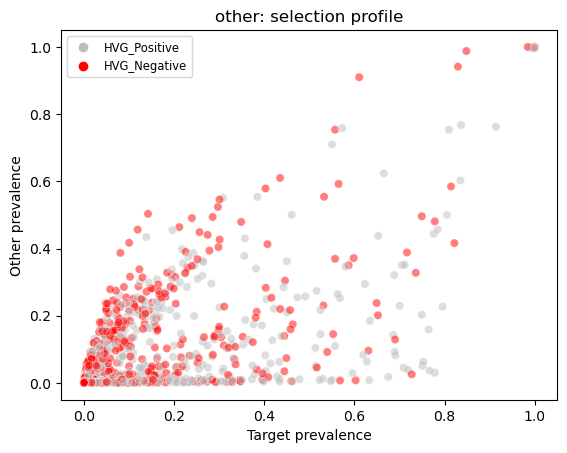

other_T


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


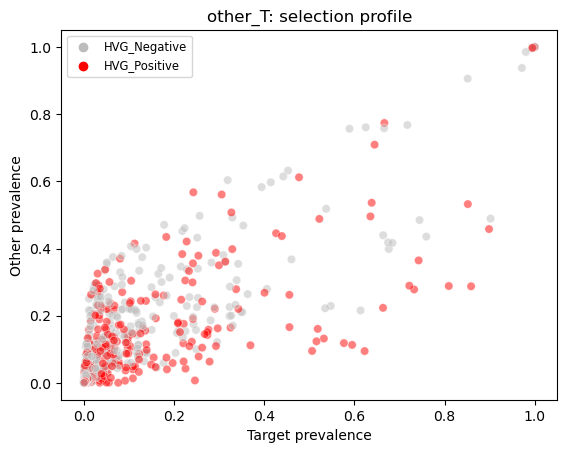

In [73]:
for celltype in types:
    print(celltype)
    plot_HVG_profile(data_hvg, celltype, save_path='/Users/evanli/Documents/EvanPys/Progress/Hao_repcells_inv/L1_lossdiff/HVG2000_LR')
